<a href="https://colab.research.google.com/github/MarinaSupiot/projet_7/blob/main/buisnes_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import space_eval, STATUS_OK
import plotly.express as px
from plotly.offline import iplot

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb
#!pip install lime
#from lime import lime_tabular

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pickle
import random
import re
import seaborn as sns
!pip install shap
import shap


import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, fbeta_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

!pip install scikit-plot
!pip install kds

import scikitplot as skplt
import kds

import pickle
import os



import time

# Versions
print('Version des librairies utilisées :')


print('Matplotlib            : ' + mpl.__version__)
print('Missingno             : ' + msno.__version__)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Seaborn               : ' + sns.__version__)
print('Shap                  : ' + shap.__version__)
print('Sklearn               : ' + sklearn.__version__ )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.7 MB/s eta 0:00:00
Version des librairies utilisées :
Matplotlib            : 3.7.1
Missingno             : 0.5.2
NumPy                 : 1.23.5
Pandas                : 1.5.3
Seaborn               : 0.13.1
Shap                  : 0.44.1
Sklearn               : 1.2.2


In [2]:
def timeit(f):
    '''
    fonction décoratrice qui donne le temps d'éxecution d'une autre fonction
    '''
    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed

In [21]:
def cout_metier(y_true, y_pred, fn_value=-10, fp_value=-1, vp_value=0, vn_value=1):
    mat_conf = confusion_matrix(y_true, y_pred)
    vn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    vp = mat_conf[1, 1]
    J = vp * vp_value + vn * vn_value + fp * fp_value + fn * fn_value
    # Coût maximum
    max_J = (fp + vn)*vn_value + (fn + vp)*vp_value

    # Coût minimum
    min_J = (fp + vn)*fp_value + (fn + vp)*fn_value

    # Coût normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)

    return J

In [ ]:
def cout_metier_2(y_true, y_pred, fn_value=-10, fp_value=-1, vp_value=0, vn_value=1):
    mat_conf = confusion_matrix(y_true, y_pred)
    vn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    vp = mat_conf[1, 1]
    J = vp * vp_value + vn * vn_value + fp * fp_value + fn * fn_value
    # Coût maximum
    max_J = (fp + vn)*vn_value + (fn + vp)*vp_value

    # Coût minimum
    min_J = (fp + vn)*fp_value + (fn + vp)*fn_value

    # Coût normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)

    return J

In [4]:
val_sample_set = pickle.load( open( "/content/drive/MyDrive/Projet 7/val_sample_set.p", "rb" ) )

In [ ]:
val_sample_set

In [6]:
val_sample_labels = pickle.load( open( "/content/drive/MyDrive/Projet 7/val_sample_labels.p", "rb" ) )

In [53]:
model_us = pickle.load(open("/content/drive/MyDrive/Projet 7/model_us.pkl", "rb"))
model_smote = pickle.load(open("/content/drive/MyDrive/Projet 7/model_smote.pkl", "rb"))
model_su06 = pickle.load(open("/content/drive/MyDrive/Projet 7/model_su06.pkl", "rb"))
model_su04 = pickle.load(open("/content/drive/MyDrive/Projet 7/model_su04.pkl", "rb"))
model_su02 = pickle.load(open("/content/drive/MyDrive/Projet 7/model_su02.pkl", "rb"))

Best result for Model SMOTE: Cout Metier - 319.000, Threshold - 0.652
Best result for Model SU06: Cout Metier - 299.000, Threshold - 0.492
Best result for Model SU04: Cout Metier - 281.000, Threshold - 0.566
Best result for Model SU02: Cout Metier - 245.000, Threshold - 0.070
Best result for Model US: Cout Metier - 299.000, Threshold - 0.492


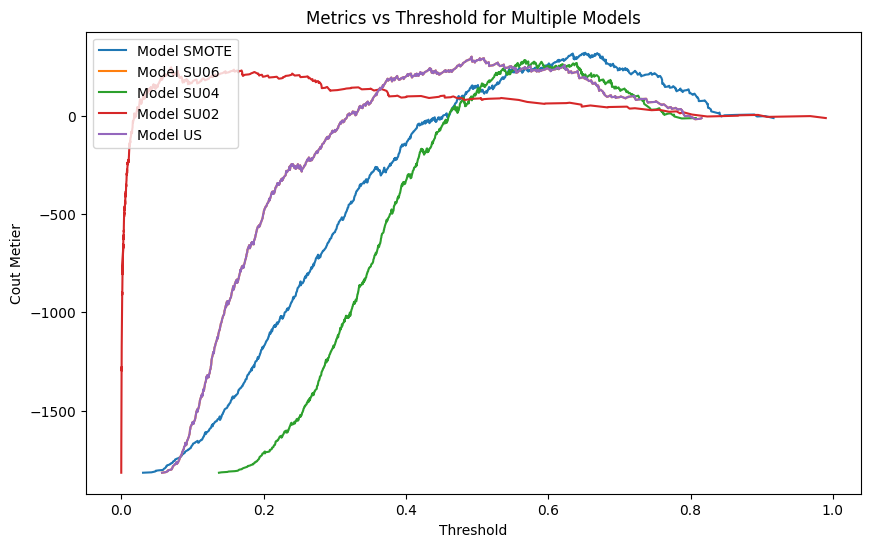

In [55]:
# Define the calculate_metrics function
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, fbeta_score
def calculate_metrics(X, y, model):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)

    # Calculate ROC AUC for different thresholds
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]

    # Calculate business cost (cout_metier) for different thresholds
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]

    # Calculate F2 score for different thresholds
    #fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds if y_pred_proba > threshold]

    return thresholds, precision, recall, roc_auc, cout_metier_values

# Modify the plot_metrics_vs_threshold function to handle multiple models
def plot_metrics_vs_threshold(models, X, y):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    for i, (model_name, model) in enumerate(models.items()):
        thresholds, precision, recall, roc_auc, cout_metier_values = calculate_metrics(X, y, model)
        ax1.plot(thresholds, cout_metier_values, color=colors[i], label=model_name)

        # Find and print the best threshold for each model based on the business cost
        max_cout_metier_idx = np.argmax(cout_metier_values)
        print(f"Best result for {model_name}: Cout Metier - {cout_metier_values[max_cout_metier_idx]:.3f}, Threshold - {thresholds[max_cout_metier_idx]:.3f}")

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Cout Metier')
    ax1.legend(loc='upper left')
    plt.title('Metrics vs Threshold for Multiple Models')
    plt.show()

# Define the dictionary of models
models = {
    'Model SMOTE': model_smote,
    'Model SU06': model_su06,
    'Model SU04': model_su04,
    'Model SU02': model_su02,
    'Model US': model_us
}

# Call the function with the dictionary of models and test data
plot_metrics_vs_threshold(models, val_sample_set.drop(columns=['TARGET']), val_sample_labels)

Adaboost

In [50]:
model_smote = pickle.load(open("/content/drive/MyDrive/Projet 7/Adaboost/model_smote.pkl", "rb"))
model_su06 = pickle.load(open("/content/drive/MyDrive/Projet 7/Adaboost/model_su06.pkl", "rb"))
model_su04 = pickle.load(open("/content/drive/MyDrive/Projet 7/Adaboost/model_su04.pkl", "rb"))
model_su02 = pickle.load(open("/content/drive/MyDrive/Projet 7/Adaboost/model_su02.pkl", "rb"))
model_us = pickle.load(open("/content/drive/MyDrive/Projet 7/Adaboost/model_us.pkl", "rb"))



Best result for Model SMOTE: Cout Metier - 271.000, Threshold - 0.499
Best result for Model SU06: Cout Metier - 313.000, Threshold - 0.426
Best result for Model SU04: Cout Metier - 319.000, Threshold - 0.397
Best result for Model SU02: Cout Metier - 315.000, Threshold - 0.459
Best result for Model US: Cout Metier - 317.000, Threshold - 0.496


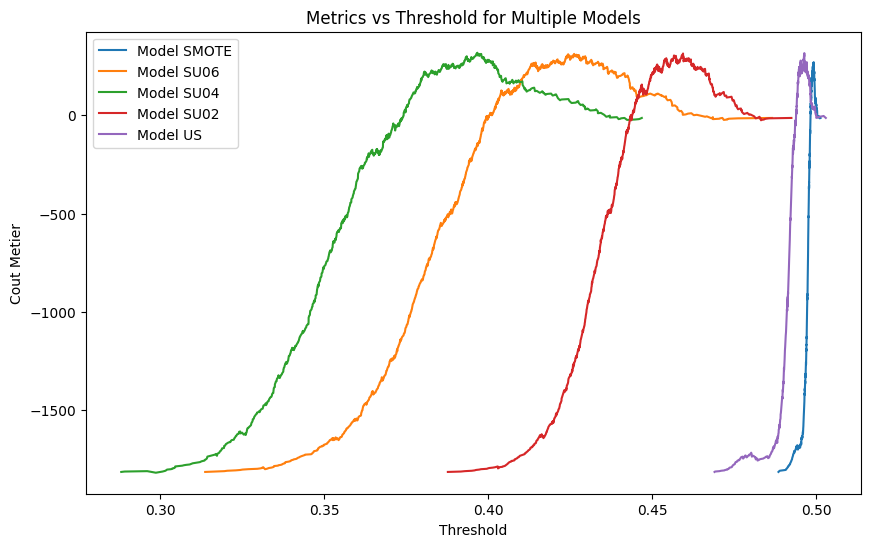

In [52]:
# Define the calculate_metrics function
def calculate_metrics(X, y, model):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)

    # Calculate ROC AUC for different thresholds
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]

    # Calculate business cost (cout_metier) for different thresholds
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]

    # Calculate F2 score for different thresholds
    #fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds if y_pred_proba > threshold]

    return thresholds, precision, recall, roc_auc, cout_metier_values

# Modify the plot_metrics_vs_threshold function to handle multiple models
def plot_metrics_vs_threshold(models, X, y):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    for i, (model_name, model) in enumerate(models.items()):
        thresholds, precision, recall, roc_auc, cout_metier_values = calculate_metrics(X, y, model)
        ax1.plot(thresholds, cout_metier_values, color=colors[i], label=model_name)

        # Find and print the best threshold for each model based on the business cost
        max_cout_metier_idx = np.argmax(cout_metier_values)
        print(f"Best result for {model_name}: Cout Metier - {cout_metier_values[max_cout_metier_idx]:.3f}, Threshold - {thresholds[max_cout_metier_idx]:.3f}")

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Cout Metier')
    ax1.legend(loc='upper left')
    plt.title('Metrics vs Threshold for Multiple Models')
    plt.show()

# Define the dictionary of models
models = {
    'Model SMOTE': model_smote,
    'Model SU06': model_su06,
    'Model SU04': model_su04,
    'Model SU02': model_su02,
    'Model US': model_us
}

# Call the function with the dictionary of models and test data
plot_metrics_vs_threshold(models, val_sample_set.drop(columns=['TARGET']), val_sample_labels)

DummyRegressor

In [40]:
model_us = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_us.pkl", "rb"))
model_smote = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_smote.pkl", "rb"))
model_su06 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_su06.pkl", "rb"))
model_su04 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_su04.pkl", "rb"))
model_su02 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_su02.pkl", "rb"))

Best result for Model SMOTE: Cout Metier - -13.000, Threshold - 1.000
Best result for Model SU06: Cout Metier - -13.000, Threshold - 1.000
Best result for Model SU04: Cout Metier - -13.000, Threshold - 1.000
Best result for Model SU02: Cout Metier - -13.000, Threshold - 1.000
Best result for Model US: Cout Metier - -13.000, Threshold - 1.000


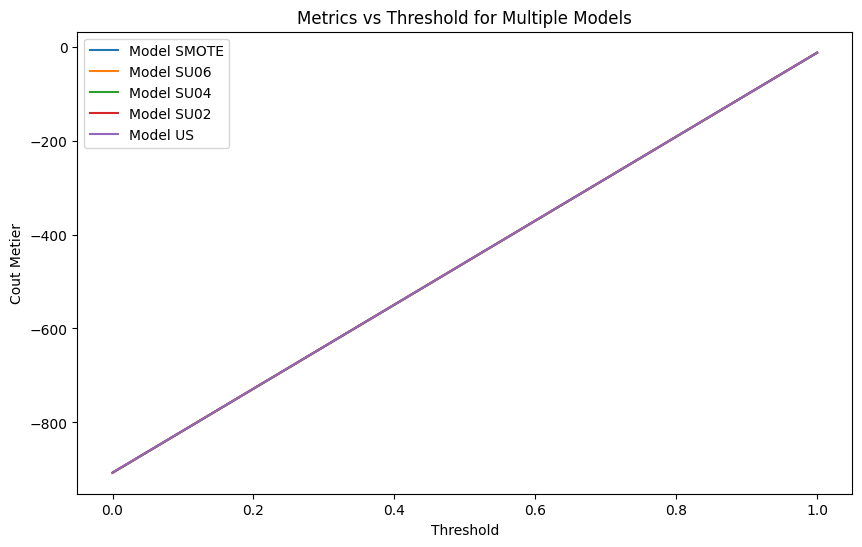

In [49]:
# Define the calculate_metrics function
def calculate_metrics(X, y, model):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)

    # Calculate ROC AUC for different thresholds
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]

    # Calculate business cost (cout_metier) for different thresholds
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]

    # Calculate F2 score for different thresholds
    #fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds if y_pred_proba > threshold]

    return thresholds, precision, recall, roc_auc, cout_metier_values

# Modify the plot_metrics_vs_threshold function to handle multiple models
def plot_metrics_vs_threshold(models, X, y):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    for i, (model_name, model) in enumerate(models.items()):
        thresholds, precision, recall, roc_auc, cout_metier_values = calculate_metrics(X, y, model)
        ax1.plot(thresholds, cout_metier_values, color=colors[i], label=model_name)

        # Find and print the best threshold for each model based on the business cost
        max_cout_metier_idx = np.argmax(cout_metier_values)
        print(f"Best result for {model_name}: Cout Metier - {cout_metier_values[max_cout_metier_idx]:.3f}, Threshold - {thresholds[max_cout_metier_idx]:.3f}")

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Cout Metier')
    ax1.legend(loc='upper left')
    plt.title('Metrics vs Threshold for Multiple Models')
    plt.show()

# Define the dictionary of models
models = {
    'Model SMOTE': model_smote,
    'Model SU06': model_su06,
    'Model SU04': model_su04,
    'Model SU02': model_su02,
    'Model US': model_us
}

# Call the function with the dictionary of models and test data
plot_metrics_vs_threshold(models, val_sample_set.drop(columns=['TARGET']), val_sample_labels)
